# P3. Permutation equivariant neural networks

1. Implement the feedforward neural network defined above. Explain your implementation.

<img src="p3.png" alt="Image" style="width:700px">

2. Train the neural network with L = 5 and w = 2. Show the training and validation loss versus the number of epochs. Compute the test MSE value. Repeat this for (L,w) set to (2,10), (2,100), (2,200), (3,5), (3,10), (3,100), and (3,200). Discuss the obtained results.

In [14]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split

# Load data and preprocess

In [10]:
# load data
x_train = pd.read_csv("xtrain-2.csv").values
y_train = pd.read_csv("ytrain-2.csv").values
x_test = pd.read_csv("xtest-2.csv").values
y_test = pd.read_csv("ytest-2.csv").values

# remove index
x_train = x_train[:, 1:]
x_test = x_test[:, 1:]
y_train = y_train[:, 1:]
y_test = y_test[:, 1:]

# reshape m=5, d=3
x_train = x_train.reshape(-1, 5, 3)
x_test = x_test.reshape(-1, 5, 3)

print(f"x_train shape: {x_train.shape}")  # (sample, 5, 3)
print(f"y_train shape: {y_train.shape}")  # (sample, 5)
print(x_train[0:3])
print(y_train[0:3])
print(x_test[0:3])
print(y_test[0:3])

x_train shape: (200000, 5, 3)
y_train shape: (200000, 5)
[[[ 0.97873798  2.2408932   1.86755799]
  [-0.97727788  0.95008842 -0.15135721]
  [-0.10321885  0.4105985   0.14404357]
  [ 1.45427351  0.76103773  0.12167502]
  [ 0.44386323  0.33367433  1.49407907]]

 [[-0.54974618 -1.40287272  1.5827523 ]
  [-1.04514683  0.25759352 -1.9593946 ]
  [-1.50780766 -0.31529207  0.85817886]
  [ 0.07134299 -2.29230928 -1.41555249]
  [ 0.8858294   0.63190187  0.04026035]]

 [[-2.1361961   1.64027081 -1.79343559]
  [-0.84174737  0.50288142 -1.24528809]
  [-1.05795222 -0.90900761  0.55145404]
  [ 2.29220801  0.04153939 -1.11792545]
  [ 0.53905832 -0.5961597  -0.0191305 ]]]
[[1 0 0 0 0]
 [0 0 0 0 1]
 [0 0 0 0 1]]
[[[ 1.40912631  0.80255916 -0.17573298]
  [ 0.96274529 -1.65587771  0.08543173]
  [ 0.28969567 -0.27130515 -0.16344025]
  [ 0.10183688 -0.50247209  0.90859133]
  [-2.10372428  0.76418082 -0.61154337]]

 [[-0.32043624 -1.97711211 -0.33710058]
  [-2.31881558 -1.79611106  2.34956074]
  [ 0.36046409 

In [11]:
# change data to tensor in pytorch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x_train_t = torch.tensor(x_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32)
x_test_t  = torch.tensor(x_test,  dtype=torch.float32)
y_test_t  = torch.tensor(y_test,  dtype=torch.float32)

# separate data and build data loader
dataset = TensorDataset(x_train_t, y_train_t)
val_size = int(0.1 * len(dataset))   # 10% 作为验证集
train_size = len(dataset) - val_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

batch_size = 300
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(TensorDataset(x_test_t, y_test_t), batch_size=batch_size, shuffle=False)

# Build equivariant layers

The key idea is that we split the transformation into 2 parts:

The local part: a 1×1 convolution applied to each item independently.

The global part: an average pooling across items to get a global feature (invariant to any permutation), then a linear mapping that is broadcast to each item.

In [12]:
# local 1×1 conv + global average pooling layer 
class EquivariantLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(EquivariantLayer, self).__init__()
        # local part: 1×1 conv
        self.local_conv = nn.Conv1d(in_channels, out_channels, kernel_size=1)
        # global part: a linear mapping applied to the average over items
        self.global_linear = nn.Linear(in_channels, out_channels, bias=False)

    def forward(self, x):
        # transpose x to use Conv1D: (batch, m, in_channels) => (batch, in_channels, m)
        x_perm = x.transpose(1, 2)  
        
        # Local transformation via 1×1 convolution => (batch, out_channels, m)
        local_out = self.local_conv(x_perm)
        # 1.Average over the item dimension => (batch_size, in_channels)
        global_feat = x_perm.mean(dim=2)     
        # 2.Map to (batch_size, out_channels) using a linear layer
        global_out = self.global_linear(global_feat)  
        # 3.Broadcast the result to match shape (batch_size, out_channels, m)
        global_out = global_out.unsqueeze(-1).expand(-1, -1, x_perm.size(2))
        
        # combine local and global
        out = local_out + global_out
        
        # transpose back to (batch_size, m, out_channels)
        return out.transpose(1, 2)

# Using layers above to build network

The first L-1 layers produce dimension w (with ReLU). The final layer outputs 1 channel per item.

Input shape: (batch_size, m, input_dim). Output shape: (batch_size, m).

In [13]:
class EquivariantNet(nn.Module):
    def __init__(self, L, w, input_dim=3):
        super(EquivariantNet, self).__init__()
        
        layers = []
        # first layer: input_dim -> w
        layers.append(EquivariantLayer(input_dim, w))
        layers.append(nn.ReLU())
        
        # middle layers (L-2): w -> w
        for _ in range(L - 2):
            layers.append(EquivariantLayer(w, w))
            layers.append(nn.ReLU()) 
        self.feature = nn.Sequential(*layers)
        
        # last layer: w -> 1
        self.output_layer = EquivariantLayer(w, 1)

    def forward(self, x):
        out = self.feature(x)         # => (batch, m, w)
        out = self.output_layer(out)  # => (batch, m, 1)
        return out.squeeze(-1)        # => (batch, m)


# Define training and validation

In [14]:
# compute training and validation loss 
def train_model(model, train_loader, val_loader, epochs=100, lr=1e-4, eps=1e-3):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, eps=eps)
    train_losses, val_losses = [], []
    
    for epoch in range(epochs):
        # training
        model.train()
        running_loss = 0.0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            pred = model(xb)
            loss = criterion(pred, yb)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * xb.size(0)
        train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(train_loss)
        
        # validation
        model.eval()
        running_val = 0.0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                pred = model(xb)
                loss = criterion(pred, yb)
                running_val += loss.item() * xb.size(0)
        val_loss = running_val / len(val_loader.dataset)
        val_losses.append(val_loss)
        
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    
    return train_losses, val_losses

# compute mse on test data.
def evaluate_model(model, test_loader):
    model.eval()
    criterion = nn.MSELoss()
    total_loss = 0.0
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            loss = criterion(pred, yb)
            total_loss += loss.item() * xb.size(0)
    return total_loss / len(test_loader.dataset)

# compute accuaracy 
def compute_accuracy(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for xb, yb in data_loader:
            xb, yb = xb.to(device), yb.to(device)
            # pred: (batch, m)
            pred = model(xb)
            pred_labels = torch.argmax(pred, dim=1)  # predict index
            true_labels = torch.argmax(yb, dim=1)    # true index
            correct += (pred_labels == true_labels).sum().item()
            total += xb.size(0)
    return correct / total

# Run the model for different (L,w)

Training Model with L=5, w=2
Epoch 1/100 | Train Loss: 0.2759 | Val Loss: 0.2032
Epoch 2/100 | Train Loss: 0.1852 | Val Loss: 0.1763
Epoch 3/100 | Train Loss: 0.1722 | Val Loss: 0.1687
Epoch 4/100 | Train Loss: 0.1661 | Val Loss: 0.1640
Epoch 5/100 | Train Loss: 0.1625 | Val Loss: 0.1614
Epoch 6/100 | Train Loss: 0.1608 | Val Loss: 0.1604
Epoch 7/100 | Train Loss: 0.1602 | Val Loss: 0.1601
Epoch 8/100 | Train Loss: 0.1600 | Val Loss: 0.1600
Epoch 9/100 | Train Loss: 0.1600 | Val Loss: 0.1600
Epoch 10/100 | Train Loss: 0.1600 | Val Loss: 0.1600
Epoch 11/100 | Train Loss: 0.1600 | Val Loss: 0.1600
Epoch 12/100 | Train Loss: 0.1600 | Val Loss: 0.1600
Epoch 13/100 | Train Loss: 0.1600 | Val Loss: 0.1600
Epoch 14/100 | Train Loss: 0.1600 | Val Loss: 0.1600
Epoch 15/100 | Train Loss: 0.1600 | Val Loss: 0.1600
Epoch 16/100 | Train Loss: 0.1600 | Val Loss: 0.1600
Epoch 17/100 | Train Loss: 0.1600 | Val Loss: 0.1600
Epoch 18/100 | Train Loss: 0.1600 | Val Loss: 0.1600
Epoch 19/100 | Train Loss:

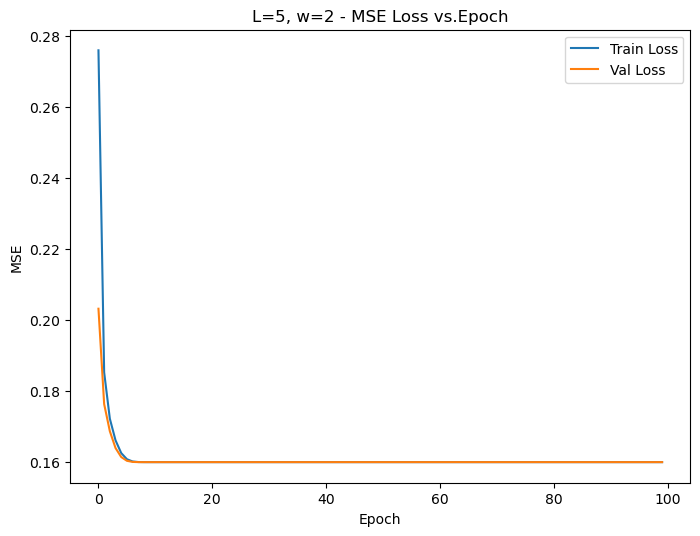

Training Model with L=2, w=10
Epoch 1/100 | Train Loss: 0.2839 | Val Loss: 0.2101
Epoch 2/100 | Train Loss: 0.1879 | Val Loss: 0.1752
Epoch 3/100 | Train Loss: 0.1701 | Val Loss: 0.1669
Epoch 4/100 | Train Loss: 0.1653 | Val Loss: 0.1641
Epoch 5/100 | Train Loss: 0.1634 | Val Loss: 0.1628
Epoch 6/100 | Train Loss: 0.1625 | Val Loss: 0.1620
Epoch 7/100 | Train Loss: 0.1618 | Val Loss: 0.1615
Epoch 8/100 | Train Loss: 0.1613 | Val Loss: 0.1611
Epoch 9/100 | Train Loss: 0.1610 | Val Loss: 0.1608
Epoch 10/100 | Train Loss: 0.1607 | Val Loss: 0.1606
Epoch 11/100 | Train Loss: 0.1606 | Val Loss: 0.1605
Epoch 12/100 | Train Loss: 0.1604 | Val Loss: 0.1604
Epoch 13/100 | Train Loss: 0.1603 | Val Loss: 0.1603
Epoch 14/100 | Train Loss: 0.1603 | Val Loss: 0.1602
Epoch 15/100 | Train Loss: 0.1602 | Val Loss: 0.1602
Epoch 16/100 | Train Loss: 0.1602 | Val Loss: 0.1601
Epoch 17/100 | Train Loss: 0.1602 | Val Loss: 0.1601
Epoch 18/100 | Train Loss: 0.1601 | Val Loss: 0.1601
Epoch 19/100 | Train Loss

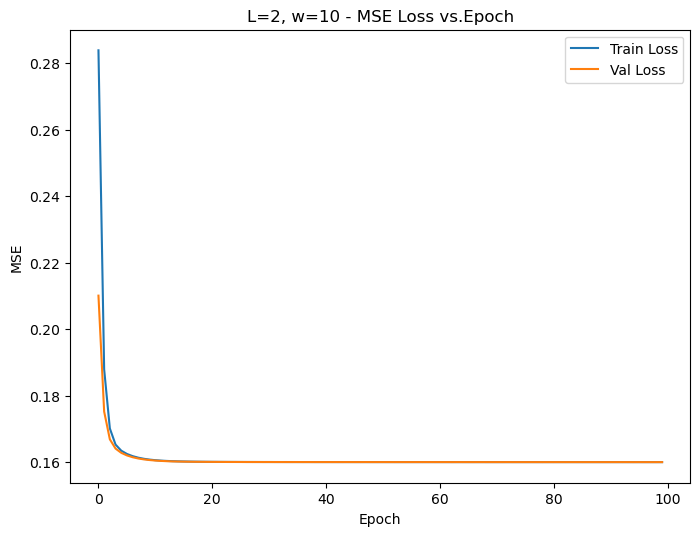

Training Model with L=2, w=100
Epoch 1/100 | Train Loss: 0.2410 | Val Loss: 0.1731
Epoch 2/100 | Train Loss: 0.1682 | Val Loss: 0.1650
Epoch 3/100 | Train Loss: 0.1637 | Val Loss: 0.1626
Epoch 4/100 | Train Loss: 0.1620 | Val Loss: 0.1615
Epoch 5/100 | Train Loss: 0.1612 | Val Loss: 0.1608
Epoch 6/100 | Train Loss: 0.1606 | Val Loss: 0.1604
Epoch 7/100 | Train Loss: 0.1602 | Val Loss: 0.1600
Epoch 8/100 | Train Loss: 0.1599 | Val Loss: 0.1597
Epoch 9/100 | Train Loss: 0.1596 | Val Loss: 0.1594
Epoch 10/100 | Train Loss: 0.1593 | Val Loss: 0.1591
Epoch 11/100 | Train Loss: 0.1590 | Val Loss: 0.1588
Epoch 12/100 | Train Loss: 0.1587 | Val Loss: 0.1585
Epoch 13/100 | Train Loss: 0.1585 | Val Loss: 0.1583
Epoch 14/100 | Train Loss: 0.1582 | Val Loss: 0.1580
Epoch 15/100 | Train Loss: 0.1580 | Val Loss: 0.1578
Epoch 16/100 | Train Loss: 0.1578 | Val Loss: 0.1576
Epoch 17/100 | Train Loss: 0.1576 | Val Loss: 0.1574
Epoch 18/100 | Train Loss: 0.1574 | Val Loss: 0.1573
Epoch 19/100 | Train Los

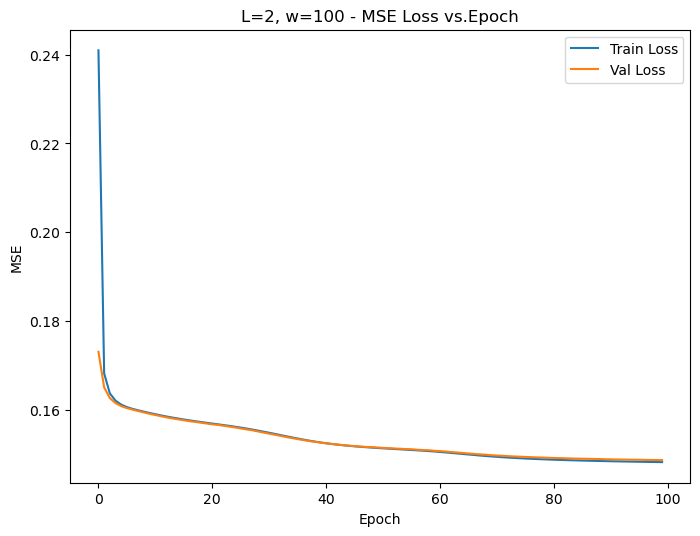

Training Model with L=2, w=200
Epoch 1/100 | Train Loss: 0.1885 | Val Loss: 0.1640
Epoch 2/100 | Train Loss: 0.1627 | Val Loss: 0.1618
Epoch 3/100 | Train Loss: 0.1612 | Val Loss: 0.1608
Epoch 4/100 | Train Loss: 0.1605 | Val Loss: 0.1603
Epoch 5/100 | Train Loss: 0.1600 | Val Loss: 0.1598
Epoch 6/100 | Train Loss: 0.1596 | Val Loss: 0.1593
Epoch 7/100 | Train Loss: 0.1591 | Val Loss: 0.1589
Epoch 8/100 | Train Loss: 0.1586 | Val Loss: 0.1583
Epoch 9/100 | Train Loss: 0.1580 | Val Loss: 0.1577
Epoch 10/100 | Train Loss: 0.1574 | Val Loss: 0.1571
Epoch 11/100 | Train Loss: 0.1567 | Val Loss: 0.1564
Epoch 12/100 | Train Loss: 0.1561 | Val Loss: 0.1559
Epoch 13/100 | Train Loss: 0.1555 | Val Loss: 0.1553
Epoch 14/100 | Train Loss: 0.1550 | Val Loss: 0.1548
Epoch 15/100 | Train Loss: 0.1545 | Val Loss: 0.1543
Epoch 16/100 | Train Loss: 0.1541 | Val Loss: 0.1539
Epoch 17/100 | Train Loss: 0.1537 | Val Loss: 0.1536
Epoch 18/100 | Train Loss: 0.1533 | Val Loss: 0.1533
Epoch 19/100 | Train Los

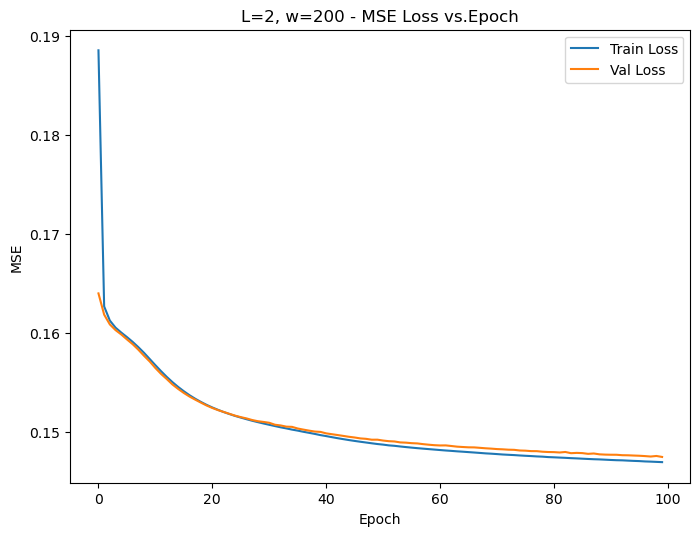

Training Model with L=3, w=5
Epoch 1/100 | Train Loss: 0.2678 | Val Loss: 0.2101
Epoch 2/100 | Train Loss: 0.1821 | Val Loss: 0.1667
Epoch 3/100 | Train Loss: 0.1639 | Val Loss: 0.1626
Epoch 4/100 | Train Loss: 0.1620 | Val Loss: 0.1617
Epoch 5/100 | Train Loss: 0.1614 | Val Loss: 0.1613
Epoch 6/100 | Train Loss: 0.1611 | Val Loss: 0.1610
Epoch 7/100 | Train Loss: 0.1609 | Val Loss: 0.1608
Epoch 8/100 | Train Loss: 0.1607 | Val Loss: 0.1607
Epoch 9/100 | Train Loss: 0.1606 | Val Loss: 0.1605
Epoch 10/100 | Train Loss: 0.1605 | Val Loss: 0.1604
Epoch 11/100 | Train Loss: 0.1604 | Val Loss: 0.1603
Epoch 12/100 | Train Loss: 0.1603 | Val Loss: 0.1603
Epoch 13/100 | Train Loss: 0.1602 | Val Loss: 0.1602
Epoch 14/100 | Train Loss: 0.1602 | Val Loss: 0.1602
Epoch 15/100 | Train Loss: 0.1602 | Val Loss: 0.1601
Epoch 16/100 | Train Loss: 0.1601 | Val Loss: 0.1601
Epoch 17/100 | Train Loss: 0.1601 | Val Loss: 0.1601
Epoch 18/100 | Train Loss: 0.1601 | Val Loss: 0.1601
Epoch 19/100 | Train Loss:

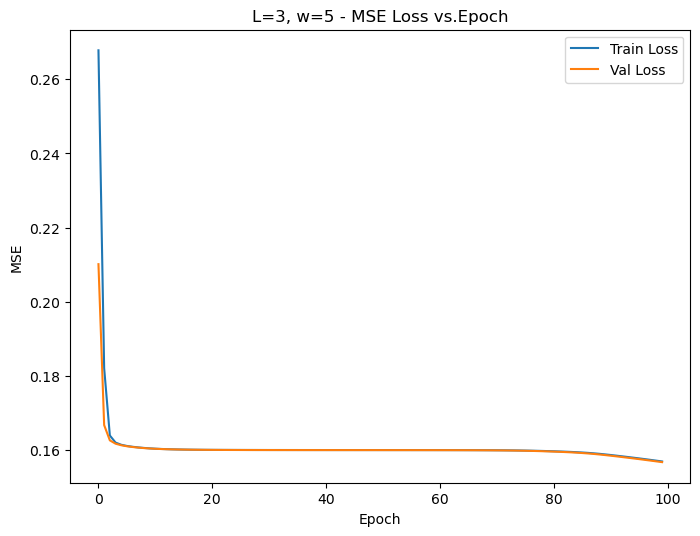

Training Model with L=3, w=10
Epoch 1/100 | Train Loss: 0.1656 | Val Loss: 0.1617
Epoch 2/100 | Train Loss: 0.1611 | Val Loss: 0.1607
Epoch 3/100 | Train Loss: 0.1605 | Val Loss: 0.1604
Epoch 4/100 | Train Loss: 0.1603 | Val Loss: 0.1602
Epoch 5/100 | Train Loss: 0.1602 | Val Loss: 0.1602
Epoch 6/100 | Train Loss: 0.1601 | Val Loss: 0.1601
Epoch 7/100 | Train Loss: 0.1601 | Val Loss: 0.1601
Epoch 8/100 | Train Loss: 0.1601 | Val Loss: 0.1601
Epoch 9/100 | Train Loss: 0.1601 | Val Loss: 0.1600
Epoch 10/100 | Train Loss: 0.1601 | Val Loss: 0.1600
Epoch 11/100 | Train Loss: 0.1600 | Val Loss: 0.1600
Epoch 12/100 | Train Loss: 0.1600 | Val Loss: 0.1600
Epoch 13/100 | Train Loss: 0.1600 | Val Loss: 0.1600
Epoch 14/100 | Train Loss: 0.1600 | Val Loss: 0.1600
Epoch 15/100 | Train Loss: 0.1600 | Val Loss: 0.1600
Epoch 16/100 | Train Loss: 0.1600 | Val Loss: 0.1600
Epoch 17/100 | Train Loss: 0.1600 | Val Loss: 0.1600
Epoch 18/100 | Train Loss: 0.1600 | Val Loss: 0.1600
Epoch 19/100 | Train Loss

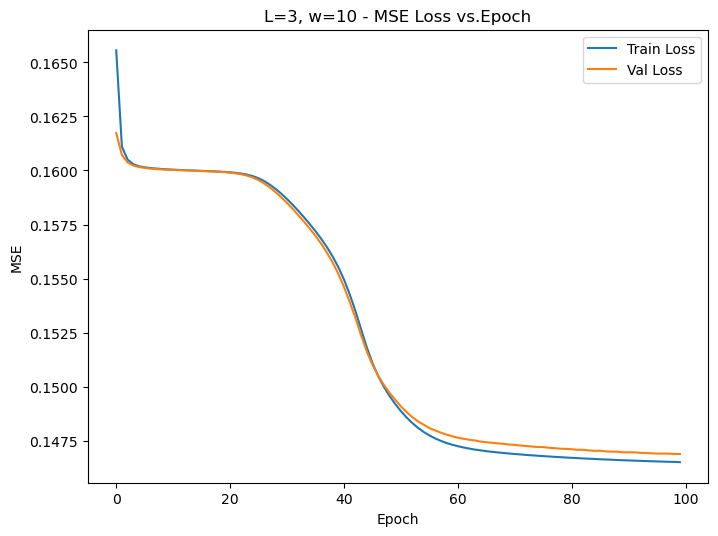

Training Model with L=3, w=100
Epoch 1/100 | Train Loss: 0.1615 | Val Loss: 0.1600
Epoch 2/100 | Train Loss: 0.1597 | Val Loss: 0.1593
Epoch 3/100 | Train Loss: 0.1591 | Val Loss: 0.1587
Epoch 4/100 | Train Loss: 0.1584 | Val Loss: 0.1580
Epoch 5/100 | Train Loss: 0.1576 | Val Loss: 0.1572
Epoch 6/100 | Train Loss: 0.1566 | Val Loss: 0.1561
Epoch 7/100 | Train Loss: 0.1555 | Val Loss: 0.1550
Epoch 8/100 | Train Loss: 0.1544 | Val Loss: 0.1539
Epoch 9/100 | Train Loss: 0.1533 | Val Loss: 0.1530
Epoch 10/100 | Train Loss: 0.1524 | Val Loss: 0.1522
Epoch 11/100 | Train Loss: 0.1517 | Val Loss: 0.1516
Epoch 12/100 | Train Loss: 0.1510 | Val Loss: 0.1511
Epoch 13/100 | Train Loss: 0.1505 | Val Loss: 0.1506
Epoch 14/100 | Train Loss: 0.1501 | Val Loss: 0.1503
Epoch 15/100 | Train Loss: 0.1497 | Val Loss: 0.1500
Epoch 16/100 | Train Loss: 0.1494 | Val Loss: 0.1497
Epoch 17/100 | Train Loss: 0.1491 | Val Loss: 0.1494
Epoch 18/100 | Train Loss: 0.1488 | Val Loss: 0.1491
Epoch 19/100 | Train Los

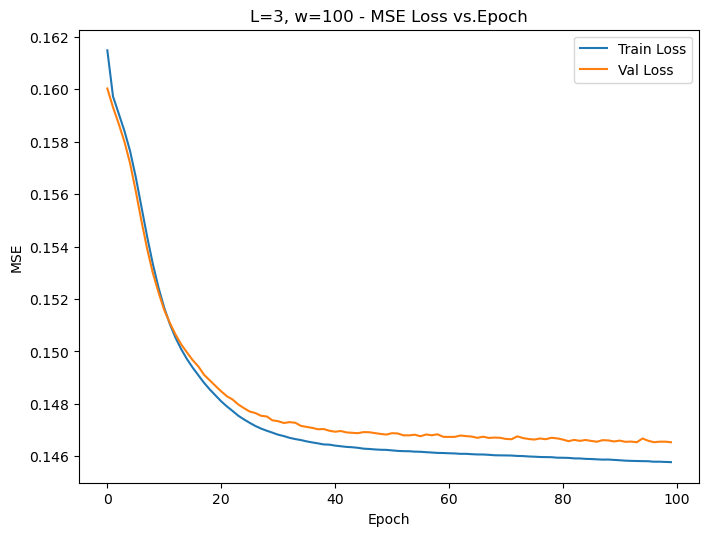

Training Model with L=3, w=200
Epoch 1/100 | Train Loss: 0.1603 | Val Loss: 0.1590
Epoch 2/100 | Train Loss: 0.1584 | Val Loss: 0.1575
Epoch 3/100 | Train Loss: 0.1567 | Val Loss: 0.1557
Epoch 4/100 | Train Loss: 0.1549 | Val Loss: 0.1542
Epoch 5/100 | Train Loss: 0.1534 | Val Loss: 0.1529
Epoch 6/100 | Train Loss: 0.1523 | Val Loss: 0.1519
Epoch 7/100 | Train Loss: 0.1514 | Val Loss: 0.1512
Epoch 8/100 | Train Loss: 0.1507 | Val Loss: 0.1506
Epoch 9/100 | Train Loss: 0.1501 | Val Loss: 0.1502
Epoch 10/100 | Train Loss: 0.1496 | Val Loss: 0.1497
Epoch 11/100 | Train Loss: 0.1491 | Val Loss: 0.1494
Epoch 12/100 | Train Loss: 0.1487 | Val Loss: 0.1491
Epoch 13/100 | Train Loss: 0.1483 | Val Loss: 0.1486
Epoch 14/100 | Train Loss: 0.1480 | Val Loss: 0.1484
Epoch 15/100 | Train Loss: 0.1477 | Val Loss: 0.1481
Epoch 16/100 | Train Loss: 0.1475 | Val Loss: 0.1479
Epoch 17/100 | Train Loss: 0.1473 | Val Loss: 0.1478
Epoch 18/100 | Train Loss: 0.1472 | Val Loss: 0.1476
Epoch 19/100 | Train Los

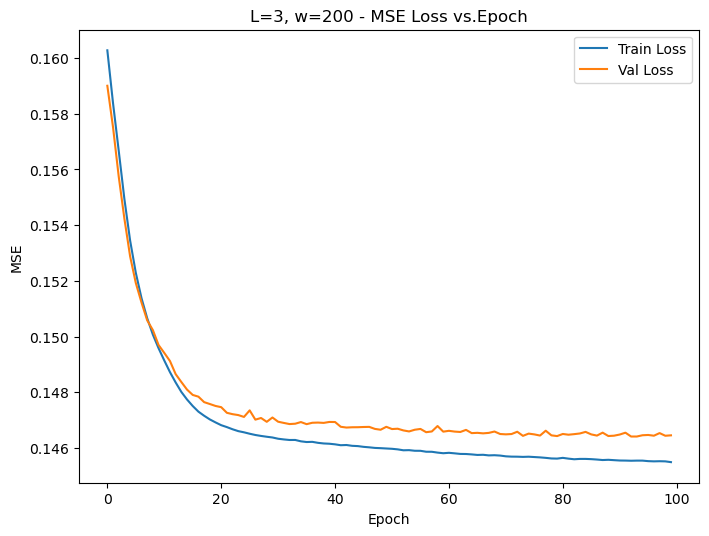


=== Final MSE results for each (L, w) ===
(L=5, w=2) => Test MSE = 0.160000
(L=2, w=10) => Test MSE = 0.160000
(L=2, w=100) => Test MSE = 0.148303
(L=2, w=200) => Test MSE = 0.147104
(L=3, w=5) => Test MSE = 0.156774
(L=3, w=10) => Test MSE = 0.146615
(L=3, w=100) => Test MSE = 0.146145
(L=3, w=200) => Test MSE = 0.146116


In [17]:
Lw = [(5, 2),(2, 10),(2, 100),(2, 200),(3, 5),(3, 10),(3, 100),(3, 200)]
results = {}
for (L, w) in Lw:
    print("=" * 60)
    print(f"Training Model with L={L}, w={w}")

    # build the model
    model = EquivariantNet(L=L, w=w, input_dim=3).to(device)
    # train
    train_losses, val_losses = train_model(model, train_loader, val_loader, epochs=100)

    # Evaluate
    test_mse = evaluate_model(model, test_loader)
    test_acc = compute_accuracy(model, test_loader)
    results[(L, w)] = test_mse

    print(f"[L={L}, w={w}] Test MSE: {test_mse:.6f}")
    #print(f"[L={L}, w={w}] Test Accuracy: {test_acc*100:.2f}%")

    plt.figure(figsize=(8, 6), dpi=100)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses,   label='Val Loss')
    plt.title(f"L={L}, w={w} - MSE Loss vs.Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("MSE")
    plt.legend()
    plt.show()  

print("\n=== Final MSE results for each (L, w) ===")
for (L, w), mse_val in results.items():
    print(f"(L={L}, w={w}) => Test MSE = {mse_val:.6f}")


From the result of different (L,w), we can find some important trends.

1. For all the configurations of (L,w), MSE reduced rapidly in the first few epoches, then behaved different but all became stable at the end.

2. When width w increased from 2 - 10 - 100 - 200, MSE reduced, but much slower after w larger than 100.

3. When the number of layers L increased from 2 to 3, it also helps to reduce MSE, but its effect is weaker compared to increasing w.

4. From the above result,(L=3,w=200) is the best choice since it achieved the lowest MSE. 

5. No overfitting was observed, indicating good generalization across different model sizes. 
But this also means our model may still need to learn more to achieve higher accuracy.